## Lab 10, Part 1:   Convolutional Neural Networks (CNN) 

In this lab, we will learn how to train CNNs. All the code is provided. The code is allowing you to prepare the data and train a CNN that classifies which digit is written in an image provided at its input. We will show how you can train 4 different CNN, ranging from simple to more complex, and let you observe how it impacts classification accuracy. 

### MNIST Data Set

MNIST is a dataset of hand-written digits. Size of each image is 28 by 28 pixels, where each pixel has values between 0 (white) and 255 (black). 

CNN training can take quite a bit of time (particularly if GPU isn't used), so we will create a training data set that uses a subset of available data. In particular, we will define the classification problem as recognizing whether a digit in an image is 7 or not. The following piece of code shows the data preparation steps.

In [2]:
#Import the required libraries
import numpy as np

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
import matplotlib.pyplot as plt
%matplotlib inline

The following block selects a subset of images from the MNIST data.

In [3]:
#Load the training and testing data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_test_orig = X_test
# Select the subset from the train data for the sake of time.
np.random.seed(1338)  # for reproducibilty!!
# The subset is composed of all the examples where the digit is 7, and 20,000 examples are not 7.
sevens = np.where(y_train == 7)[0].tolist()
not_sevens = np.where(y_train != 7)[0].tolist()
num_keepers = 20000
not_sevens = np.random.choice(not_sevens, num_keepers, replace=False).tolist()

subset = sevens + not_sevens
np.random.shuffle(subset) # shuffle the input

X_train = X_train[subset, :, :]
y_train = y_train[subset]

The following code creates training and test data. It would be great if you can spend a few minutes trying to understand what is going on.

In [4]:
from keras import backend as K

img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    shape_ord = (1, img_rows, img_cols)
else:  # channel_last
    shape_ord = (img_rows, img_cols, 1)

# Normalize the images:

X_train = X_train.reshape((X_train.shape[0],) + shape_ord)
X_test = X_test.reshape((X_test.shape[0],) + shape_ord)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

# Create labels:

# Converting the labels to binary classification(Seven =1,Not Seven=0)
Y_train = (y_train == 7).astype(int)
Y_test = (y_test == 7).astype(int)

# Converting the classes to its binary categorical form
nb_classes = 2
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

**Question 1.** What are the dimensions of X_train, X_test, Y_train and Y_test? What are ranges of numbers in each of those?

In [37]:
print ("The Dimension of X_train is ",X_train.shape)
print ("The Dimension of X_test is ",X_test.shape)
print ("The Dimension of Y_train is ",Y_train.shape)
print ("The Dimension of Y_test is ",Y_test.shape)


The Dimension of X_train is  (26265, 28, 28, 1)
The Dimension of X_test is  (10000, 28, 28, 1)
The Dimension of Y_train is  (26265, 2)
The Dimension of Y_test is  (10000, 2)


### Answer 1
- The range for values in X_train and X_test are values bewteen 0 to 1 which is an indication of basically how bright a pixel is. Values like (0,0.1231414141,etc.)
- The range of values in Y_train and Y_test is just either 0 or 1 as they are an indication of whether image is a seven(1) or not a seven(0).

### Train a simple CNN (CNN, model 1)

The following code will show how you can define CNN, train it, and test its accuracy. 

**Step 0.** The following is a preparation step, specifying the hyperparameters.

In [3]:
# -- Initializing the values for the convolution neural network

nb_epoch = 2  # kept very low! Please increase if you have GPU

batch_size = 64
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

# Vanilla SGD
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

**Step 1.** In this step we define architecture of the CNN

Each line "model.add()" adds another layer to the neural network. The type of layer must be specified. 

In [7]:
model = Sequential()

model.add(Conv2D(nb_filters, (nb_conv, nb_conv), padding='valid', 
                 input_shape=shape_ord))  # note: the very first layer **must** always specify the input_shape
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(26, 26)))
model.add(Flatten())
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

We can check the configuration of the above model by call model.summary()

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________


**Question 2.** From the above summary, can you explain the architecture of this CNN?

**ANSWER 2** 

- First the conv2d_2 takes each image which initally was a 28 by 28 by 1 picture and changes shape to a 26 x 26 x 32 tensor by applying 32 3x3 filters to it when padding is not used which causes the edges of image to be lost thus 26 x26. As you can see the parameter is 320 due to how in this part it is learning and thus there are 9 differnt weights from the 3x3 filter plus 1 other intial weight for each filter thus 320=32 * (3* 3+1)   
- The Second part is just bascially going through some function to change values like a relu one to ignore negative values.
- The max_pooling2d_2 chnages the 26x26x32 tensor to a 1x1x32 tensor by basically taking the max value in each layer (26x26) thus creating basically 32 values.
- Flatten just changes structure so we change the dimension of the tensor to a vector or an array of 32 values.
- The Dense uses the 32 values to learn by creating a neural network which has 32 inputs and 2 outputs. As we can see the learning param in this case was 66 which in a network is just the number of weights or lines in network plus 2 intial weights so 66= 32 * 2 + 2.
- The activation_4 part is where the decison is made on whether or not picture is seven or not by looking at the values and whichever is greater that spot's mapping becomes the predicted classfication. Example (0.1,0.9) -> (0,1)-> the CNN predicts the image was a seven as the 0.9 maps to 1 classfication which means picture was a seven.

**Step 2.** Here, we define the loss function. You will see that the loss function is not Mean Square Error, but Cross Entropy. Cross Entropy is a very popular choice when training neural networks for classification problems.

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

**Step 3.** This line of code trains CNN. This is going to take about a minute. Observe that we will only have 2 epochs of training, in the iterest of time. You will see how the accuracy on training and valiadion data evolves during training.

In [10]:
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 epochs=nb_epoch, verbose=1, 
                 validation_data=(X_test, Y_test))

Train on 26265 samples, validate on 10000 samples
Epoch 1/2
26265/26265 [==============================] - 14s 536us/step - loss: 0.3752 - acc: 0.8617 - val_loss: 0.6252 - val_acc: 0.6784
Epoch 2/2
26265/26265 [==============================] - 14s 537us/step - loss: 0.2626 - acc: 0.9069 - val_loss: 0.6806 - val_acc: 0.6597


Let us plot the accuracy. 

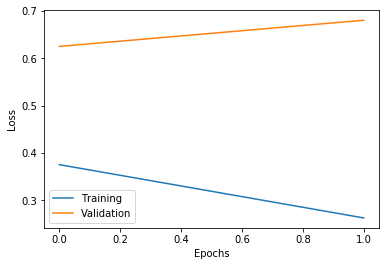

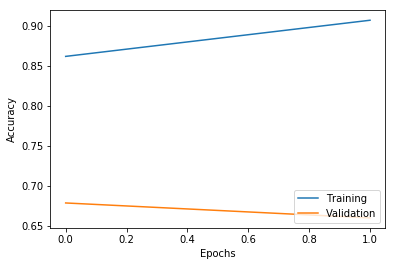

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

**Step 4.** Evaluate the accuracy on test data.

In [12]:
# Evaluating the model on the test data    
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Test Loss: 0.6805530346870422
Test Accuracy: 0.6597


Let us visualize our model Predictions!

In [13]:
import matplotlib.pyplot as plt

%matplotlib inline

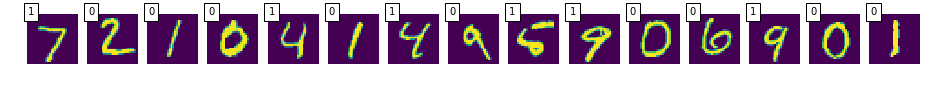

In [14]:
slice = 15
predicted = model.predict(X_test[:slice]).argmax(-1)

plt.figure(figsize=(16,8))
for i in range(slice):
    plt.subplot(1, slice, i+1)
    plt.imshow(X_test_orig[i], interpolation='nearest')
    plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

**Question 3.** Can you discuss the performance of the CNN model? What kind of errors is it making?

**ANSWER 3**
- The performance of the CNN Model i not great as the accuracy is only 66% which is not good at all. Looking at the graphs we can see that as the accruacy of training data was increasing the validation accuracy was decreasing showing how some sort of overfitting was occuring.
- The mistakes the Model seems to be making is in the recognition of the numbers 4, 5, and 9 the model thinks they are 7. This is possible for value like 4 and 9 as both have a straight vertical and horiztional part like 7 does which could be the reasoning for the errors.

**Question 4.** Run the training for 10 epochs. How did it impact the accuracy?

In [15]:
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 epochs=10, verbose=1, 
                 validation_data=(X_test, Y_test))

Train on 26265 samples, validate on 10000 samples
Epoch 1/10
26265/26265 [==============================] - 14s 550us/step - loss: 0.2216 - acc: 0.9217 - val_loss: 0.1057 - val_acc: 0.9662
Epoch 2/10
26265/26265 [==============================] - 14s 551us/step - loss: 0.2068 - acc: 0.9259 - val_loss: 0.2843 - val_acc: 0.8827
Epoch 3/10
26265/26265 [==============================] - 15s 553us/step - loss: 0.1915 - acc: 0.9308 - val_loss: 0.1116 - val_acc: 0.9620
Epoch 4/10
26265/26265 [==============================] - 16s 599us/step - loss: 0.2033 - acc: 0.9273 - val_loss: 0.1006 - val_acc: 0.9646
Epoch 5/10
26265/26265 [==============================] - 15s 562us/step - loss: 0.1841 - acc: 0.9338 - val_loss: 0.1223 - val_acc: 0.9559
Epoch 6/10
26265/26265 [==============================] - 15s 560us/step - loss: 0.1876 - acc: 0.9306 - val_loss: 0.1914 - val_acc: 0.9261
Epoch 7/10
26265/26265 [==============================] - 17s 634us/step - loss: 0.1893 - acc: 0.9307 - val_loss: 0.

nTest Loss: 0.09183419832140208
Test Accuracy: 0.9697


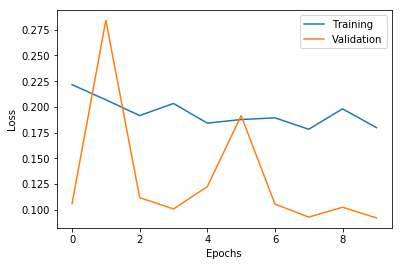

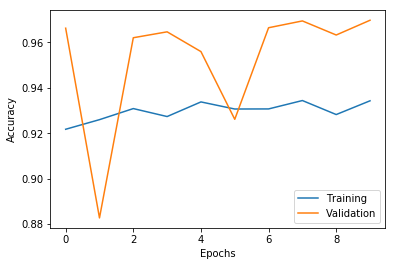

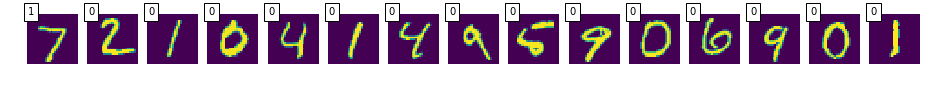

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

# Evaluating the model on the test data    
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('nTest Loss:', loss)
print('Test Accuracy:', accuracy)

slice = 15
predicted = model.predict(X_test[:slice]).argmax(-1)

plt.figure(figsize=(16,8))
for i in range(slice):
    plt.subplot(1, slice, i+1)
    plt.imshow(X_test_orig[i], interpolation='nearest')
    plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

### ANSWER 4
Overall we can see that the new CNN with 10 epochs was able to train much better with an accuracy of 96.9% on test data (increase of 30%). We can also see that even though there is fluctation of the validation accuracy it increased overall.

### Train a more complicated CNN (CNN, model 2)

Now, we will define a more complicated CNN architecture.

In [17]:
model = Sequential()
model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                 padding='valid', input_shape=shape_ord))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_3 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               692352    
_________________________________________________________________
activation_4 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
__________

**Question 5.** Can you explain the architecture of this CNN (model 2) and how is it different from the first CNN you trained (model 1)? Compare their performance by looking at the visualizstions.

**ANSWER 5**
<p>
- The conv2d_2 is the same process in applying 32 filters as well as the activation is basically same.  
- The max_pooling2d_2 changes now has before it changed the 26x26x32 tensor to a 1x1x32 tensor, but now only changes it to a 13x13x32 as now each layer is split into tiny 2x2 segments in which the max value in each of those tiny sections is taken repeated for each layer thus making it a 13x13x32.
- Flatten just changes structure so we change the dimension of the tensor to a vector or an array of 5408 values (13* 13 * 32).
- The Dense2 uses the 5408 values to learn by creating a neural network which has 5408 inputs and 128 outputs. As we can see the learning param in this case was 692352 which in a network is just the number of weights or lines in network plus 128 intial weights(for each output) so 692352= 5408 * 128 + 128.
- The activation is another function the values go through to better them.
- The Dense 3 is now another neural network which uses the 128 values as inputs and  creates 2 outputs. 258 is param as 258= 128 * 2 + 2.
- The activation_5 part is where the decison is made like we saw before.
<\p>    
Overall we can see from the visuals below that the validation accuracy and testing accuracy are no longer fluctuating but very much smoother with both contintously increasing.

In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

hist=model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_data=(X_test, Y_test))

Train on 26265 samples, validate on 10000 samples
Epoch 1/2
26265/26265 [==============================] - 20s 777us/step - loss: 0.0811 - acc: 0.9732 - val_loss: 0.0659 - val_acc: 0.9793
Epoch 2/2
26265/26265 [==============================] - 20s 775us/step - loss: 0.0744 - acc: 0.9757 - val_loss: 0.0624 - val_acc: 0.9799


In [24]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 0.062398138776421544
Test accuracy: 0.9799


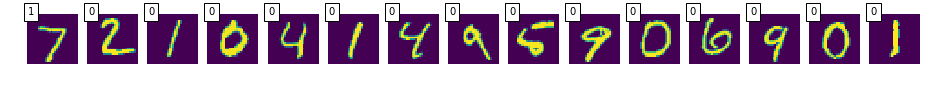

In [25]:
slice = 15
predicted = model.predict(X_test[:slice]).argmax(-1)

plt.figure(figsize=(16,8))
for i in range(slice):
    plt.subplot(1, slice, i+1)
    plt.imshow(X_test_orig[i], interpolation='nearest')
    plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

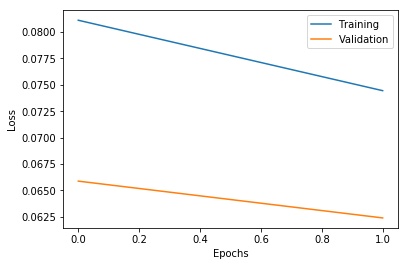

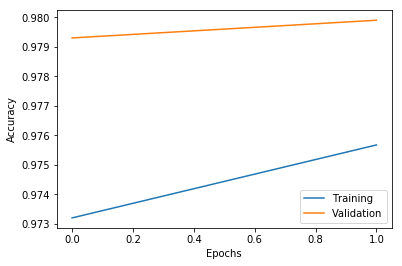

In [26]:
# ANSWER 5
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

Wow! We have lifted the accuracy from 70.4% to 97.8%. This model can figure out the two "4"s  are not 7, but still be confused by pesky "9"! 

### Adding more convolutional layers and MaxPooling layers (CNN, model 3)

Now, we will define an even more complicated CNN architecture.

In [31]:
model = Sequential()
model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                 padding='valid', input_shape=shape_ord))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Conv2D(nb_filters, (nb_conv, nb_conv), 
                 padding='valid'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Flatten())
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_8 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1602      
__________

In [33]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_data=(X_test, Y_test))

Train on 26265 samples, validate on 10000 samples
Epoch 1/2
26265/26265 [==============================] - 26s 991us/step - loss: 0.2923 - acc: 0.8762 - val_loss: 0.0980 - val_acc: 0.9770
Epoch 2/2
26265/26265 [==============================] - 26s 988us/step - loss: 0.1040 - acc: 0.9657 - val_loss: 0.0676 - val_acc: 0.9802


In [34]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 0.06761694045439362
Test accuracy: 0.9802


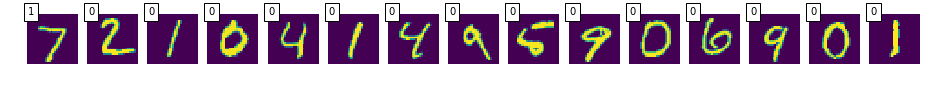

In [35]:
slice = 15
predicted = model.predict(X_test[:slice]).argmax(-1)

plt.figure(figsize=(16,8))
for i in range(slice):
    plt.subplot(1, slice, i+1)
    plt.imshow(X_test_orig[i], interpolation='nearest')
    plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

Another 0.2 % lift from 97.8% to 98.0%. This model sees clearly "9" is different than "7"! 

### Wrapping all the code together and play with hyperparameters

The code below wraps up the pieces of codes above into a single function and allows you to play with the hyperparameters by changing the arguments.


In [11]:
# Function for constructing the convolution neural network
# Feel free to add parameters, if you want

def build_model(num_conv = 1, conv_activation = "relu", num_dense = 1, dense_activation  = "relu", 
               dropout = True, max_pooling = True,nb_epoch=2):
    """"""
    model = Sequential()
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv), 
                     padding='valid',
                     input_shape=shape_ord))
    model.add(Activation(conv_activation))
    
    for i in range(num_conv-1):
        model.add(Conv2D(nb_filters, (nb_conv, nb_conv)))
        model.add(Activation(conv_activation))
        
    if max_pooling is True:
        model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
        
    if dropout is True:
        model.add(Dropout(0.25))
    
    model.add(Flatten())

    if dropout is True:
        model.add(Dropout(0.5))
    
    for i in range(num_dense-1):
        model.add(Dense(128))
        model.add(Activation(dense_activation))
        
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

    model.fit(X_train, Y_train, batch_size=batch_size, 
              epochs=nb_epoch,verbose=1,
              validation_data=(X_test, Y_test))
          

    #Evaluating the model on the test data  
    model.summary()
    score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print(num_conv , 'convolutional layers,', num_dense, "dense layers")
    if max_pooling: print("With max pooling")
    if dropout: print("With dropout")
    print('Test score:', score)
    print('Test accuracy:', accuracy)
    slice = 15
    predicted = model.predict(X_test[:slice]).argmax(-1)

    plt.figure(figsize=(16,8))
    for i in range(slice):
        plt.subplot(1, slice, i+1)
        plt.imshow(X_test_orig[i], interpolation='nearest')
        plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
        plt.axis('off')
    

An example of running this function

Train on 26265 samples, validate on 10000 samples
Epoch 1/2
26265/26265 [==============================] - 25s 938us/step - loss: 0.2293 - acc: 0.9148 - val_loss: 0.0894 - val_acc: 0.9779
Epoch 2/2
26265/26265 [==============================] - 23s 866us/step - loss: 0.1259 - acc: 0.9570 - val_loss: 0.0764 - val_acc: 0.9785
1 convolutional layers, 1 dense layers
With max pooling
With dropout
Test score: 0.07641849129796029
Test accuracy: 0.9785


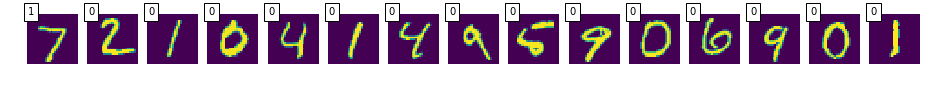

In [37]:
# Here is an example of running build_model() with default hyperparameters
build_model()

Train on 26265 samples, validate on 10000 samples
Epoch 1/2
26265/26265 [==============================] - 136s 5ms/step - loss: 0.2720 - acc: 0.8849 - val_loss: 0.0871 - val_acc: 0.9726
Epoch 2/2
26265/26265 [==============================] - 135s 5ms/step - loss: 0.1158 - acc: 0.9587 - val_loss: 0.0587 - val_acc: 0.9813
3 convolutional layers, 3 dense layers
With max pooling
With dropout
Test score: 0.05870024533122778
Test accuracy: 0.9813


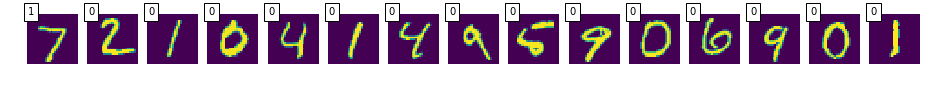

In [38]:
# Here is an example of running build_model() with new hyperparameters
build_model(num_conv = 3, num_dense = 3)

Train on 26265 samples, validate on 10000 samples
Epoch 1/2
26265/26265 [==============================] - 24s 923us/step - loss: 0.2256 - acc: 0.9150 - val_loss: 0.0880 - val_acc: 0.9765
Epoch 2/2
26265/26265 [==============================] - 22s 836us/step - loss: 0.1269 - acc: 0.9558 - val_loss: 0.0724 - val_acc: 0.9792
1 convolutional layers, 1 dense layers
With max pooling
With dropout
Test score: 0.07242986221313477
Test accuracy: 0.9792
49.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


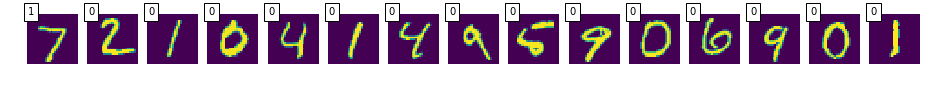

In [39]:
#Timing how long it takes to build the model and test it.
%timeit -n1 -r1 build_model()

**Question 6.** Try to change some of the **hyperparameters** without exploding the computational resources on your computer. 
What is the best accuracy you can get? How many parameters are there of each model? How long does the training take? Maybe increase the amount of data used? What does that do to the accuracy and training time? 

Train on 26265 samples, validate on 10000 samples
Epoch 1/2
26265/26265 [==============================] - 90s 3ms/step - loss: 0.2163 - acc: 0.9105 - val_loss: 0.0663 - val_acc: 0.9798
Epoch 2/2
26265/26265 [==============================] - 80s 3ms/step - loss: 0.1095 - acc: 0.9615 - val_loss: 0.0586 - val_acc: 0.9815
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_34 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_35 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_8 (M

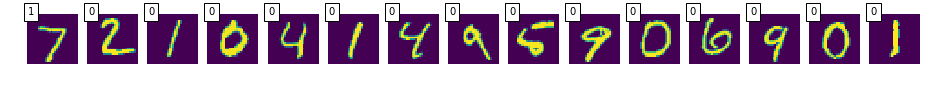

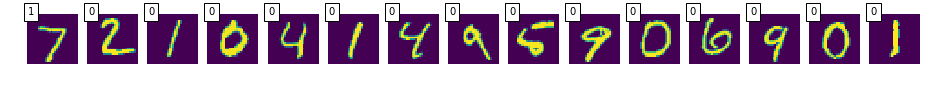

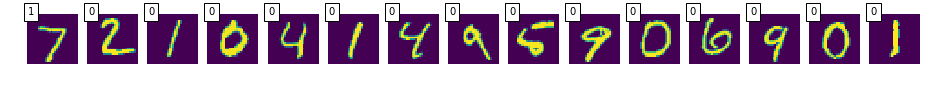

In [23]:
bestAccuracy=0.0
bestConv=1
bestDense=1
for conv in range(2,3):
    for dense in range(2,5):
        accuracy=build_model(num_conv=conv,num_dense=dense)
        if(accuracy>bestAccuracy):
            bestAccuracy=accuracy
            bestConv=conv
            bestDense=dense
print("Best Accuracy ", bestAccuracy)
print("Best Convultional Layers ",bestConv )
print("Best Dense Layers ",bestDense ) 

Train on 31265 samples, validate on 10000 samples
Epoch 1/2
31265/31265 [==============================] - 113s 4ms/step - loss: 0.1989 - acc: 0.9198 - val_loss: 0.0655 - val_acc: 0.9807
Epoch 2/2
31265/31265 [==============================] - 117s 4ms/step - loss: 0.0995 - acc: 0.9640 - val_loss: 0.0592 - val_acc: 0.9821
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_41 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_42 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_9 

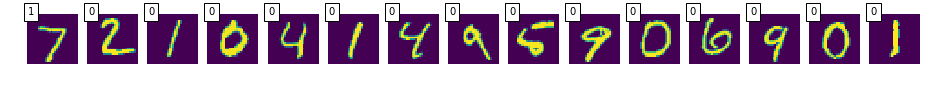

In [30]:
#Load the training and testing data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_test_orig = X_test

# Select the subset from the train data for the sake of time.
np.random.seed(1338)  # for reproducibilty!!
# The subset is composed of all the examples where the digit is 7, and 20,000 examples are not 7.
sevens = np.where(Y_train == 7)[0].tolist()
not_sevens = np.where(Y_train != 7)[0].tolist()
num_keepers = 25000
not_sevens = np.random.choice(not_sevens, num_keepers, replace=False).tolist()

subset = sevens + not_sevens
np.random.shuffle(subset) # shuffle the input

X_train = X_train[subset, :, :]
Y_train = Y_train[subset]

from keras import backend as K

img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    shape_ord = (1, img_rows, img_cols)
else:  # channel_last
    shape_ord = (img_rows, img_cols, 1)

# Normalize the images:

X_train = X_train.reshape((X_train.shape[0],) + shape_ord)
X_test = X_test.reshape((X_test.shape[0],) + shape_ord)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

# Create labels:

# Converting the labels to binary classification(Seven =1,Not Seven=0)
Y_train = (Y_train == 7).astype(int)
Y_test = (Y_test == 7).astype(int)

# Converting the classes to its binary categorical form
nb_classes = 2
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

%timeit -n1 -r1 build_model(num_conv=2,num_dense=2)

### Answer 6

- Overall we saw that using 2 number of convuentional layers and 2 number of dense layers the accruacy wa the highest when we had 20,000 examples.
- When we increased the training data it did increased the accruacy from 98.15 to 98.21% so a very slight increase when the time to train also slighlty inceased.

#### Question 7 (20% of the grade)

Can you train a model to output 10 classes instead of 2 binary classes? We can use this model to classify images into 10 digits of the mnist data set. Again, we will only train our model on a subset of the training data. The following steps will help you to build such a model.

    * 1. Select 20,000 examples randomly from X_train, since we want all 10 digits present in our training data.
    * 2. Convert Y_train and Y_test to categorical.
    * 3. Call the build_model() on the X_train and Y_train.

In [19]:
#Load the training and testing data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_test_orig = X_test

# Select the subset from the train data for the sake of time.
np.random.seed(1338)  # for reproducibilty!!

rand = np.random.randint(X_train.shape[0], size=20000)


# Gets 20,000 random 
X_train = X_train[rand]
Y_train = Y_train[rand]

print(X_train.shape)
print(Y_train.shape)

(20000, 28, 28)
(20000,)


(20000, 10)
(10000, 10)
Train on 20000 samples, validate on 10000 samples
Epoch 1/2
20000/20000 [==============================] - 18s 908us/step - loss: 1.2870 - acc: 0.6411 - val_loss: 0.5447 - val_acc: 0.8626
Epoch 2/2
20000/20000 [==============================] - 19s 961us/step - loss: 0.5696 - acc: 0.8264 - val_loss: 0.4044 - val_acc: 0.8879
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_3 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 13, 13, 32)        0         
________________________________________________________

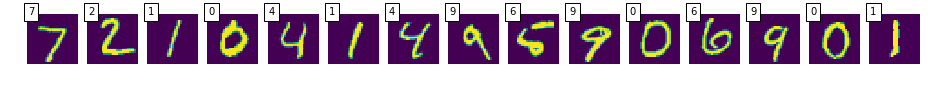

In [20]:
from keras import backend as K

img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    shape_ord = (1, img_rows, img_cols)
else:  # channel_last
    shape_ord = (img_rows, img_cols, 1)

# Normalize the images:

X_train = X_train.reshape((X_train.shape[0],) + shape_ord)
X_test = X_test.reshape((X_test.shape[0],) + shape_ord)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255



# Converting the classes to its binary categorical form
nb_classes = 10
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)
print(Y_train.shape)
print(Y_test.shape)
build_model()

#### Question 8 (30% of the grade) 

Train a model on CIFAR10 dataset, which is described in https://www.cs.toronto.edu/~kriz/cifar.html. You can load the dataset from Keras, too. CIFAR10 small image classification contains 50,000 32x32 color training images, labeled over 10 categories, and 10,000 test images.

```python
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
```

Again, we will only train our model on a subset of the training data. The following steps will help you to build such a model.

    * 1. Select 20,000 examples randomly from X_train, since we want all 10 categories present in our training data.
    * 2. Convert Y_train and Y_test to categorical.
    * 3. Call the build_model() on the X_train and Y_train.

In [26]:
from keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
X_test_orig =X_test

In [27]:
# Select the subset from the train data for the sake of time.
np.random.seed(1338)  # for reproducibilty!!

rand = np.random.randint(X_train.shape[0], size=40000)


# Gets 20,000 random 
X_train = X_train[rand]
Y_train = Y_train[rand]

print(X_train.shape)
print(Y_train.shape)

(40000, 32, 32, 3)
(40000, 1)


(40000, 10)
(10000, 10)
Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 206s 5ms/step - loss: 2.1672 - acc: 0.1880 - val_loss: 1.9591 - val_acc: 0.2896
Epoch 2/5
40000/40000 [==============================] - 227s 6ms/step - loss: 1.8911 - acc: 0.3170 - val_loss: 1.9146 - val_acc: 0.3232
Epoch 3/5
40000/40000 [==============================] - 231s 6ms/step - loss: 1.7116 - acc: 0.3796 - val_loss: 1.5812 - val_acc: 0.4272
Epoch 4/5
40000/40000 [==============================] - 226s 6ms/step - loss: 1.5819 - acc: 0.4273 - val_loss: 1.5036 - val_acc: 0.4558
Epoch 5/5
40000/40000 [==============================] - 231s 6ms/step - loss: 1.4951 - acc: 0.4585 - val_loss: 1.4052 - val_acc: 0.4946
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 30, 30, 32)        896       
___________________________________________

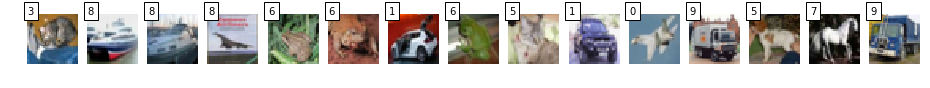

In [28]:
from keras import backend as K

img_rows, img_cols = 32, 32

if K.image_data_format() == 'channels_first':
    shape_ord = (1, img_rows, img_cols)
else:  # channel_last
    shape_ord = (img_rows, img_cols, 3)

Y_train=np.squeeze(np.asarray(Y_train))
Y_test=np.squeeze(np.asarray(Y_test))    
# Normalize the images:

X_train = X_train.reshape((X_train.shape[0],) + shape_ord)
X_test = X_test.reshape((X_test.shape[0],) + shape_ord)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255



# Converting the classes to its binary categorical form
nb_classes = 10
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)
print(Y_train.shape)
print(Y_test.shape)
build_model(num_conv=2,num_dense=3,nb_epoch=5)

-    To increase accuracy, I used 40,000 training data as well as increase the epoch count. If I had more computer resources the accuracy could increase as it does increase just at a slow rate. When I intially started with 20,000 examples of training data  and with the standard buildmodel the accuracy was only 29% but after making a more complex CNN and increasing data I was able to attain 49.46% accuracy which if we just look at the pictures it seems to be able to recongize that boats are a category of 8 but so is a plane so there is still error.